s## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:

- Гринда Юліана (LZ77, Huffman)
- Павлосюк Роман (LZW, Звіт з тестами)

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

# Алгоритм Гаффмана

В цьому алгоритмі доцільно імплементувати клас node та додаткові функції в Huffman для побудови дерева кодування

In [18]:
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __repr__(self) -> str:
        return f'{self.char}: {self.freq}'

class Huffman:
    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        letters = {letter: '' for letter in text}
        nodes = sorted([Node(letter, text.count(letter) /
                             len(text)) for letter in letters], key = lambda x: x.freq)
        tree = self.build_tree(nodes)
        alphabet = self.alphabet_code(tree, letters)
        result = ''
        for char in text:
            result += alphabet[char]
        return (result, alphabet)

    def build_tree(self, nodes):
        while len(nodes) > 1:
            left_node = nodes.pop(0)
            right_node = nodes.pop(0)
            parent_node = Node(None, left_node.freq + right_node.freq)
            parent_node.left = left_node
            parent_node.right = right_node
            nodes.append(parent_node)
            nodes = sorted(nodes, key = lambda x: x.freq)

        return nodes[0]

    def alphabet_code(self, node, letters, code = ''):
        if not node.char is None:
            letters[node.char] = code
        else:
            for i in range(2):
                if i == 0:
                    code_ = code + '0'
                    self.alphabet_code(node.left, letters, code_)
                else:
                    code_ = code + '1'
                    self.alphabet_code(node.right, letters, code_)
        return letters

    def decode(self, code: str, coding_dict: dict[str, str]):
        coding_dict = {value: key for key, value in coding_dict.items()}
        result = ''
        match_ = ''
        for char in code:
            if match_ + char in coding_dict:
                result += coding_dict[match_ + char]
                match_ = ''
            else:
                match_ += char
        return result


# Алгоритм LZW

In [19]:
class LZW:
    def encode(self, text:str) -> tuple[str, list]:
        '''LZW encoding'''
        output = []
        w = ''
        start_dictionary = {}
        counter = 0
        for letter in text:
            if letter not in start_dictionary:
                start_dictionary[letter] = counter
                counter += 1
        new_dictionary = start_dictionary.copy()
        for letter in text:
            if w + letter in new_dictionary:
                w += letter
            else:
                new_dictionary.update({w + letter: max(new_dictionary.values())+1})
                output.append(new_dictionary[w])
                w = letter
        output.append(new_dictionary[w])
        return output, list(start_dictionary.keys())

    def decode(self, code: list, coding_dict: list) -> str:
        '''LZW decoding'''
        coding_dict = {i:el for i,el in enumerate(coding_dict)}
        string = coding_dict[code[0]]
        output = ''
        output += string
        counter = max(coding_dict.keys()) + 1
        for i in range(len(code)-1):
            new = code[i + 1]
            if new not in coding_dict:
                entry = string + string[0]
            else:
                entry = coding_dict[new]
            output += entry
            coding_dict[counter] = string + entry[0]
            counter += 1
            string = entry
        return output


# Алгоритм LZ77

Потрібно заміряти розміри саме тексту, проте для роботи доцільно використовувати список тюплів, тому для зручності варто імплементувати додаткові алгоритми _text2list та _list2text

In [20]:
class LZ77:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size

    def encode(self, text: str) -> str:
        encoded_data = []
        current_index = 0

        while current_index < len(text):
            best_offset = -1
            best_length = -1
            best_match = ''

            for length in range(1, min(len(text) - current_index, self.buffer_size)):
                sub_data = text[current_index:current_index + length]
                offset = text.rfind(sub_data, max(0, current_index - self.buffer_size), current_index)

                if offset != -1 and length > best_length:
                    best_offset = current_index - offset
                    best_length = length
                    best_match = sub_data

            if best_match:
                encoded_data.append((best_offset, best_length, text[current_index + best_length]))
                current_index += best_length + 1
            else:
                encoded_data.append((0, 0, text[current_index]))
                current_index += 1

        return encoded_data

    def decode(self, code: str) -> str:
        decoded_data = []

        for item in code:
            offset, length, code_word = item

            if not length:
                decoded_data.append(code_word)
            else:
                start = len(decoded_data) - offset
                substring = decoded_data[start:start + length]
                decoded_data.extend(substring)
                decoded_data.append(code_word)

        return ''.join(decoded_data)

# Алгоритм Deflate

In [21]:
class Deflate:
    def __init__(self, buffer_size: int):
        pass

    def encode(self, text: str) -> str:
        pass

    def decode(self, code: str) -> str:
        pass

# Час виконання алгоритмів на різних розмірах
Тут ми прописали три види розміру тексту(малий, середній, великий), порахували час за який алгоритми зашифрують та розшифрують дані, також зробили, щоб це було на 100 ітераціях, щоб була більш об'єктивна оцінка

In [22]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

lzw = LZW()
lz77 = LZ77(5)
huffman = Huffman()

text_message1 = 'TOBEORNOTTOBEORTOBEORNOT'

text_message2 = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod \
tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud \
exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor \
in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint \
occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'

text_message3 = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla quam justo, ullamcorper at mauris id, gravida sodales felis. \
Vestibulum quam est, hendrerit ac pellentesque a, porta et purus. Quisque est metus, varius quis dolor at, suscipit vestibulum lectus. Nulla \
pharetra ligula tincidunt tellus fermentum, sed iaculis felis molestie. Aenean at placerat nulla, quis luctus ipsum. Maecenas rutrum scelerisque \
purus, vel iaculis nisl hendrerit at. Integer ut tellus id odio tincidunt tristique vitae a nisl. Interdum et malesuada fames ac ante ipsum primis \
in faucibus. Morbi non libero vitae lectus tincidunt imperdiet. Morbi eget metus maximus, aliquam ex non, eleifend nibh. Lorem ipsum dolor sit amet, \
consectetur adipiscing elit. Cras varius urna sed mi volutpat sagittis. Curabitur aliquam venenatis neque nec accumsan. Nulla ac turpis magna. Cras \
id auctor risus. Aenean feugiat pharetra mi. Nunc at nulla magna. Nullam id molestie elit. Nulla ultricies, purus eget posuere bibendum, ligula nulla \
pretium urna, auctor interdum ex enim id ante. Quisque eu posuere nibh, id euismod magna. Aenean ultrices nibh ac consequat suscipit. Vivamus placerat, \
erat sed placerat dignissim, sapien diam tempus erat, mollis fermentum elit mi ut ipsum. Pellentesque eu dictum sem. Aliquam ultrices id nisi sit amet \
condimentum. Nunc sodales nibh faucibus nunc porttitor fringilla. Vestibulum a mi nibh. Etiam facilisis consectetur orci, facilisis ornare nisi porta \
laoreet. Phasellus ut ex quam. Quisque in vulputate sem, et malesuada est. Donec posuere feugiat quam accumsan rhoncus. Nullam tincidunt vitae ipsum \
luctus semper. Fusce mattis nec elit suscipit finibus. Etiam aliquam a enim sed tempor. Phasellus volutpat leo quis dui molestie, eu facilisis massa \
gravida. Sed euismod ante sapien, non pellentesque tellus fringilla non. Vivamus dignissim turpis sit amet mauris tincidunt maximus. Maecenas id massa \
sit amet ex accumsan sollicitudin. Interdum et malesuada fames ac ante ipsum primis in faucibus. Maecenas massa tortor, pulvinar viverra purus ullamcorper, \
porta venenatis diam. Etiam egestas aliquam urna sit amet porta. Nullam varius justo lorem, at elementum turpis facilisis eu. In vel rhoncus felis, laoreet \
vestibulum ante. Curabitur porttitor mi augue, quis laoreet libero ultricies in. Duis porttitor ex fringilla viverra iaculis. Suspendisse vestibulum molestie \
mi, eu ornare arcu semper vitae. Maecenas mattis tortor non diam rutrum, in volutpat sapien imperdiet. Maecenas nibh lorem, molestie consectetur diam non, \
tincidunt suscipit augue. Etiam eget nisl neque. Phasellus in auctor ante, quis porttitor ex. Curabitur ultricies dictum nunc, ac ultricies ligula. Donec \
ultricies tincidunt erat, at ullamcorper ligula eleifend id. Aliquam erat volutpat. Donec ac euismod lorem. Maecenas est nisl, ultrices eu accumsan sit \
amet, porttitor at orci. Interdum et malesuada fames ac ante ipsum primis in faucibus. Donec vulputate ex sit amet maximus mattis. Phasellus bibendum id \
lorem eget ultricies. Aliquam convallis, elit a porta commodo, dui ipsum suscipit nunc, at sagittis massa eros eget tortor. Duis dignissim fringilla dictum. \
Praesent at vestibulum eros, nec tempus augue. Aenean volutpat mauris leo, at auctor diam finibus in. Vestibulum erat est, convallis vitae dui sed, rutrum tincidunt magna. \
Vivamus sagittis mi vestibulum dolor condimentum, nec fermentum orci fringilla. Phasellus sit amet nulla leo. Maecenas mollis sagittis suscipit. \
Mauris pretium massa massa. Fusce tincidunt viverra bibendum. In risus urna, rhoncus ut dapibus a, lacinia sit amet tellus. Duis vitae justo a tortor \
venenatis aliquam. Etiam porttitor cursus diam, quis hendrerit tellus lobortis nec. Class aptent taciti sociosqu ad litora torquent per conubia nostra, \
per inceptos himenaeos. Quisque sagittis lacinia justo, eget suscipit mi eleifend et. Integer interdum ligula nec neque eleifend volutpat. Nunc felis leo, \
efficitur vitae tempor sit amet, laoreet quis tellus. Maecenas suscipit in ex non finibus. Pellentesque at pellentesque metus, ac posuere neque. '

num_of_iterations = 100

sizes = [text_message1, text_message2, text_message3]

for i,size in enumerate(sizes):

    lzw_time_taken_encoding = 0
    lz77_time_taken_encoding = 0
    huffman_time_taken_encoding = 0

    lzw_time_taken_decoding = 0
    lz77_time_taken_decoding = 0
    huffman_time_taken_decoding = 0

    for _ in tqdm(range(num_of_iterations)):

        start_en_lzw = time.time()
        lzw_encoding = lzw.encode(size)
        end_en_lzw = time.time()
        lzw_time_taken_encoding += end_en_lzw - start_en_lzw

        start_de_lzw = time.time()
        lzw_decoding = lzw.decode(lzw_encoding[0], lzw_encoding[1])
        end_de_lzw = time.time()
        lzw_time_taken_decoding += end_de_lzw - start_de_lzw

        start_en_lz77 = time.time()
        lz77_encoding = lz77.encode(size)
        end_en_lz77 = time.time()
        lz77_time_taken_encoding += end_en_lz77 - start_en_lz77

        start_de_lz77 = time.time()
        lz77_decoding = lz77.decode(lz77_encoding)
        end_de_lz77 = time.time()
        lz77_time_taken_decoding += end_de_lz77 - start_de_lz77

        start_en_huff = time.time()
        huff_encoding = huffman.encode(size)
        end_en_huff = time.time()
        huffman_time_taken_encoding += end_en_huff - start_en_huff

        start_de_huff = time.time()
        huff_decoding = huffman.decode(huff_encoding[0], huff_encoding[1])
        end_de_huff = time.time()
        huffman_time_taken_decoding += end_de_huff - start_de_huff

    match i:
        case 0:
            lzw_test_1 = [lzw_time_taken_encoding/100, lzw_time_taken_decoding/100]
            lz77_test_1 = [lz77_time_taken_encoding/100, lz77_time_taken_decoding/100]
            huffman_test_1 = [huffman_time_taken_encoding/100, huffman_time_taken_decoding/100]
        case 1:
            lzw_test_2 = [lzw_time_taken_encoding/100, lzw_time_taken_decoding/100]
            lz77_test_2 = [lz77_time_taken_encoding/100, lz77_time_taken_decoding/100]
            huffman_test_2 = [huffman_time_taken_encoding/100, huffman_time_taken_decoding/100]
        case 2:
            lzw_test_3 = [lzw_time_taken_encoding/100, lzw_time_taken_decoding/100]
            lz77_test_3 = [lz77_time_taken_encoding/100, lz77_time_taken_decoding/100]
            huffman_test_3 = [huffman_time_taken_encoding/100, huffman_time_taken_decoding/100]

# print(lzw_test_1, lzw_test_2, lzw_test_3)
# print(lz77_test_1, lz77_test_2, lz77_test_3)
# print(huffman_test_1, huffman_test_2, huffman_test_3)


100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


# Малий (24 символи)
Графік залежності часу виконання на шифрування на розшифрування алгоритмів на тексті малого розміру

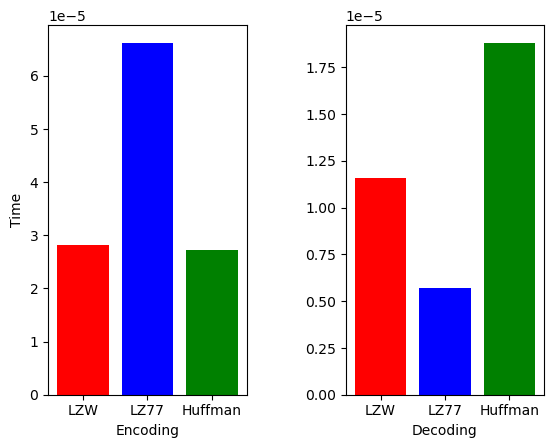

In [23]:
methods = ["LZW", "LZ77", "Huffman"]
colors = ["red", "blue", "green"]


encoding_data = [lzw_test_1[0], lz77_test_1[0], huffman_test_1[0]]
decoding_data = [lzw_test_1[1], lz77_test_1[1], huffman_test_1[1]]

plt.subplot(121)
plt.bar(methods, encoding_data, label=methods, color=colors)
plt.xlabel("Encoding")
plt.ylabel("Time")

plt.subplot(122)
plt.bar(methods, decoding_data, label="Час декодування", color=colors)
plt.xlabel("Decoding")

plt.subplots_adjust(wspace=0.5)

plt.show()


# Середній(445 символів)
Графік залежності часу виконання на шифрування на розшифрування алгоритмів на тексті середнього розміру

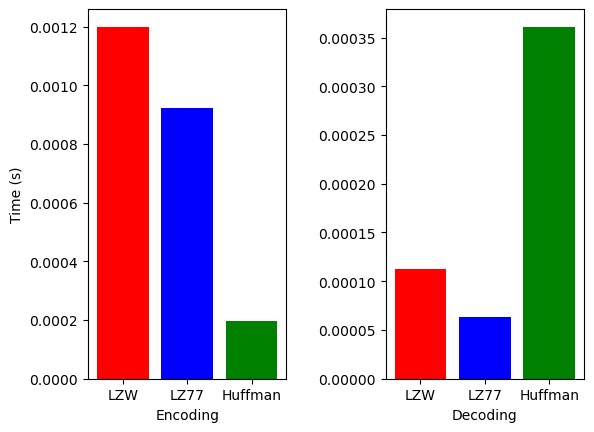

In [24]:
encoding_data = [lzw_test_2[0], lz77_test_2[0], huffman_test_2[0]]
decoding_data = [lzw_test_2[1], lz77_test_2[1], huffman_test_2[1]]

plt.subplot(121)
plt.bar(methods, encoding_data, label=methods, color=colors)
plt.xlabel("Encoding")
plt.ylabel("Time (s)")

plt.subplot(122)
plt.bar(methods, decoding_data, label="Час декодування", color=colors)
plt.xlabel("Decoding")

plt.subplots_adjust(wspace=0.5)

plt.show()

# Великий(4066 символів)
Графік залежності часу виконання на шифрування на розшифрування алгоритмів на тексті великого розміру

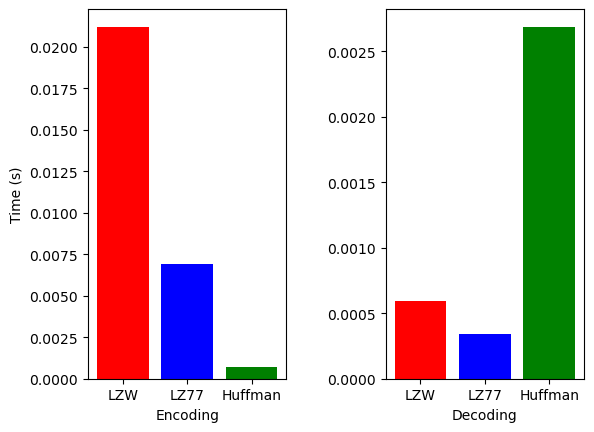

In [25]:
encoding_data = [lzw_test_3[0], lz77_test_3[0], huffman_test_3[0]]
decoding_data = [lzw_test_3[1], lz77_test_3[1], huffman_test_3[1]]

plt.subplot(121)
plt.bar(methods, encoding_data, label=methods, color=colors)
plt.xlabel("Encoding")
plt.ylabel("Time (s)")

plt.subplot(122)
plt.bar(methods, decoding_data, label="Decoding time", color=colors)
plt.xlabel("Decoding")

plt.subplots_adjust(wspace=0.5)

plt.show()

In [37]:
import sys

def compare_compression(input: str, output: str) -> int:
    '''Get difference in data size before and after compression'''
    return f"{round((1 - (sys.getsizeof(input) / sys.getsizeof(output)))*100, 1)}%"

print('LZW:')
print(f"Compression percentage: +{compare_compression(text_message1, lzw.encode(text_message1)[0])} on small data size")
print(f"Compression percentage: +{compare_compression(text_message2, lzw.encode(text_message2)[0])} on medium data size")
print(f"Compression percentage: +{compare_compression(text_message3, lzw.encode(text_message3)[0])} on big data size\n")

print('LZ77:')
print(f"Compression percentage: +{compare_compression(text_message1, lz77.encode(text_message1))} on small data size")
print(f"Compression percentage: +{compare_compression(text_message2, lz77.encode(text_message2))} on medium data size")
print(f"Compression percentage: +{compare_compression(text_message3, lz77.encode(text_message3))} on big data size\n")

print('Huffman:')
print(f"Compression percentage: +{compare_compression(text_message1, huffman.encode(text_message1)[0])} on small data size")
print(f"Compression percentage: +{compare_compression(text_message2, huffman.encode(text_message2)[0])} on medium data size")
print(f"Compression percentage: +{compare_compression(text_message3, huffman.encode(text_message3)[0])} on big data size\n")

LZW:
Compression percentage: +60.3% on small data size
Compression percentage: +80.4% on medium data size
Compression percentage: +71.3% on big data size

LZ77:
Compression percentage: +70.6% on small data size
Compression percentage: +84.8% on medium data size
Compression percentage: +84.2% on big data size

Huffman:
Compression percentage: +32.4% on small data size
Compression percentage: +73.9% on medium data size
Compression percentage: +76.3% on big data size



# Капельку про кожен алгоритм

- LZW: Найкраще використовувати на малому файлі,але загалом працює гірше, ніж LZ77 чи Гаффман, також треба взяти до уваги те, що Deflate, який використовується дуже в багатьох стискачах є поєднанням саме LZ77 i Гаффмана

* LZ77: Золота середина серед них, найкраще себе показав на великому файлі, розкодувавши найшвидше, але однаково недостатньо добре, як це зробив Гаффман

- Гаффман: Єдиним мінусом цього алгоритму є це його розкодування,враховуючи що він ще будує дерево. Але загалом є найкращим в серед зазначених вище.

# Порівняння алгоритів (висновки)

- На графіках чітко видно, що алгоритм Гаффмана дуже неоднозначний, адже кодує він дуже швидко, а ось розкодовує найдовше не в залежності від розміру файлу.
* На малому файлі напевно найбільш стабільним є LZW, але найшвидше розкодовує все-таки LZ77
- На середньому файлі найкраще закодовує Гаффман, але з іншої сторони в рази довше розкодовує, на графіку чітко видно різницю між кодуванням та розкодуванням кожного з алгоритмів,і нема якогось стабільного, але LZ77 є найбільш приближеним до найкращого варіанту
* На великому файлі Гаффман майже моментально закодовує, а LZ77 розкодовує LZW тут показав себе найгірше. Загалом тут певно найкращий буде Гаффман, бо якраз різниця між часом кодування і розкодування є найменшою серед інших